<a href="https://colab.research.google.com/github/akshaya-code/Assignment1/blob/master/RLPlacementwithdummydatset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [17]:
import random
import math
import matplotlib.pyplot as plt
from typing import Dict, List, Tuple

CHIP_WIDTH = 100
CHIP_HEIGHT = 100

macros = {
    "macro1": {"width": 20, "height": 20, "x": 0, "y": 0},
    "macro2": {"width": 20, "height": 20, "x": 80, "y": 0},
    "macro3": {"width": 20, "height": 20, "x": 0, "y": 80},
    "macro4": {"width": 20, "height": 20, "x": 80, "y": 80}
}

cells = {
    "cell1": {"width": 10, "height": 5},
    "cell2": {"width": 8, "height": 4},
    "cell3": {"width": 6, "height": 6},
    "cell4": {"width": 12, "height": 7},
    "cell5": {"width": 9, "height": 5},
    "cell6": {"width": 7, "height": 4}
}

nets = {
    "net1": ["cell1", "cell2", "macro1"],
    "net2": ["cell2", "cell3", "cell4"],
    "net3": ["cell4", "macro2"],
    "net4": ["cell5", "cell6", "macro3"],
    "net5": ["cell1", "cell6", "macro4"],
    "net6": ["cell3", "cell5"]
}

for name, props in cells.items():
    props["x"] = random.randint(0, CHIP_WIDTH - props["width"])
    props["y"] = random.randint(0, CHIP_HEIGHT - props["height"])

def calculate_total_hpwl(nets: Dict[str, List[str]], all_cells: Dict[str, Dict]) -> float:
    total_hpwl = 0.0
    for net, connected in nets.items():
        xs = [all_cells[node]["x"] + all_cells[node]["width"] // 2 for node in connected]
        ys = [all_cells[node]["y"] + all_cells[node]["height"] // 2 for node in connected]
        hpwl = (max(xs) - min(xs)) + (max(ys) - min(ys))
        total_hpwl += hpwl
    return total_hpwl



In [18]:
def plot_placement(cells: Dict[str, Dict], macros: Dict[str, Dict]):
    fig, ax = plt.subplots(figsize=(6, 6))
    ax.set_xlim(0, CHIP_WIDTH)
    ax.set_ylim(0, CHIP_HEIGHT)
    ax.set_aspect('equal')

    for name, props in macros.items():
        rect = plt.Rectangle((props["x"], props["y"]), props["width"], props["height"], color='red', alpha=0.6)
        ax.add_patch(rect)
        ax.text(props["x"] + 1, props["y"] + 1, name, fontsize=8, color='black')

    for name, props in cells.items():
        rect = plt.Rectangle((props["x"], props["y"]), props["width"], props["height"], color='blue', alpha=0.6)
        ax.add_patch(rect)
        ax.text(props["x"] + 1, props["y"] + 1, name, fontsize=8, color='white')

    ax.set_title("Initial Placement")
    plt.grid(True)
    plt.show()


In [19]:
import numpy as np

class PlacementEnv:
    def __init__(self, cells, macros, nets, chip_width, chip_height):
        self.original_cells = cells
        self.macros = macros
        self.nets = nets
        self.chip_width = chip_width
        self.chip_height = chip_height
        self.cell_names = list(cells.keys())
        self.reset()

    def reset(self):
        self.cells = {name: props.copy() for name, props in self.original_cells.items()}
        for name, props in self.cells.items():
            props["x"] = random.randint(0, self.chip_width - props["width"])
            props["y"] = random.randint(0, self.chip_height - props["height"])
        self.all_cells = {**self.cells, **self.macros}
        return self.get_state()

    def get_state(self):
        return [(props["x"], props["y"]) for props in self.cells.values()]

    def step(self, action):
        idx, dx, dy = action
        cell_name = self.cell_names[idx]
        cell = self.cells[cell_name]

        new_x = min(max(cell["x"] + dx, 0), self.chip_width - cell["width"])
        new_y = min(max(cell["y"] + dy, 0), self.chip_height - cell["height"])
        cell["x"], cell["y"] = new_x, new_y
        self.all_cells[cell_name]["x"], self.all_cells[cell_name]["y"] = new_x, new_y

        reward = self.get_reward()
        return self.get_state(), reward

    def get_reward(self):
        total_hpwl = calculate_total_hpwl(self.nets, self.all_cells)
        overlap_penalty = 0
        for i, name1 in enumerate(self.cell_names):
            cell1 = self.cells[name1]
            for j in range(i + 1, len(self.cell_names)):
                name2 = self.cell_names[j]
                cell2 = self.cells[name2]
                if self.is_overlapping(cell1, cell2):
                    overlap_penalty += 100

        boundary_penalty = 0
        for cell in self.cells.values():
            if not (0 <= cell["x"] <= self.chip_width - cell["width"]):
                boundary_penalty += 50
            if not (0 <= cell["y"] <= self.chip_height - cell["height"]):
                boundary_penalty += 50

        return -(total_hpwl + overlap_penalty + boundary_penalty)

    def is_overlapping(self, c1, c2):
        return not (
            c1["x"] + c1["width"] <= c2["x"] or
            c2["x"] + c2["width"] <= c1["x"] or
            c1["y"] + c1["height"] <= c2["y"] or
            c2["y"] + c2["height"] <= c1["y"]
        )


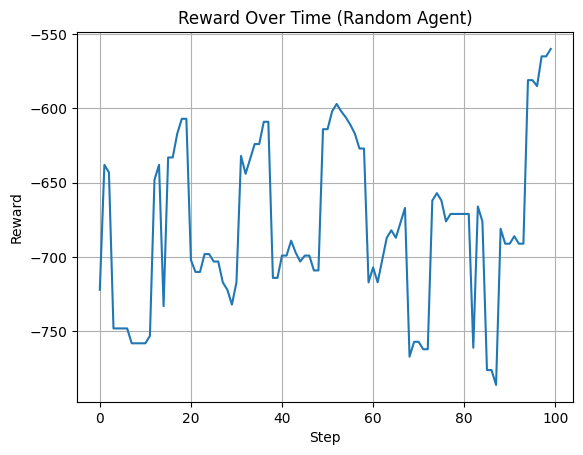

In [20]:
env = PlacementEnv(cells, macros, nets, CHIP_WIDTH, CHIP_HEIGHT)
state = env.reset()

rewards = []
for _ in range(100):
    cell_idx = random.randint(0, len(env.cell_names) - 1)
    dx = random.choice([-5, 0, 5])
    dy = random.choice([-5, 0, 5])
    action = (cell_idx, dx, dy)
    state, reward = env.step(action)
    rewards.append(reward)

plt.plot(rewards)
plt.title("Reward Over Time (Random Agent)")
plt.xlabel("Step")
plt.ylabel("Reward")
plt.grid(True)
plt.show()


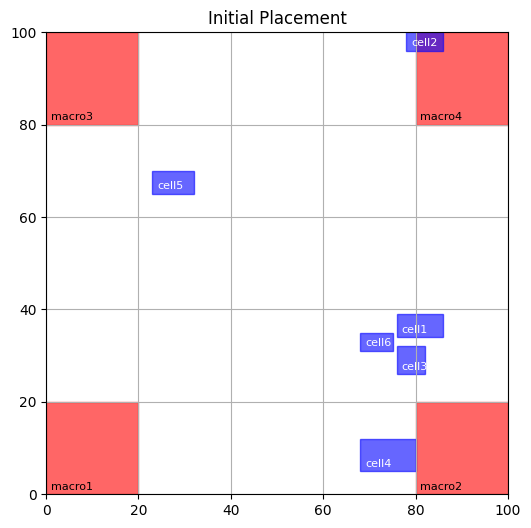

In [21]:
plot_placement(env.cells, macros)


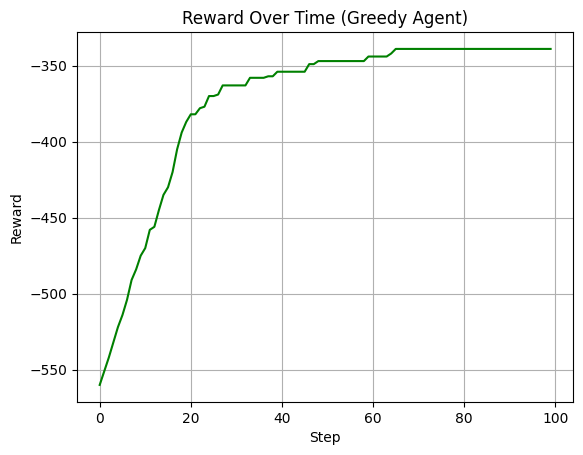

In [22]:
# Greedy Agent: Try random moves and only accept those that improve the reward

class GreedyPlacementAgent:
    def __init__(self, env):
        self.env = env

    def run(self, steps=100):
        rewards = []
        state = self.env.reset()
        current_reward = self.env.get_reward()

        for _ in range(steps):
            best_move = None
            best_reward = current_reward

            for _ in range(10):  # Try 10 random moves, pick the best
                cell_idx = random.randint(0, len(self.env.cell_names) - 1)
                dx = random.choice([-5, 0, 5])
                dy = random.choice([-5, 0, 5])
                action = (cell_idx, dx, dy)

                # Save old position
                cell_name = self.env.cell_names[cell_idx]
                cell = self.env.cells[cell_name]
                old_x, old_y = cell["x"], cell["y"]

                # Apply move
                self.env.step(action)
                reward = self.env.get_reward()

                # Revert
                cell["x"], cell["y"] = old_x, old_y
                self.env.all_cells[cell_name]["x"], self.env.all_cells[cell_name]["y"] = old_x, old_y

                if reward > best_reward:
                    best_reward = reward
                    best_move = action

            if best_move:
                state, current_reward = self.env.step(best_move)
            rewards.append(current_reward)

        return rewards

# Instantiate and run the greedy agent
greedy_agent = GreedyPlacementAgent(env)
greedy_rewards = greedy_agent.run(steps=100)

# Plot reward trend
plt.plot(greedy_rewards, color='green')
plt.title("Reward Over Time (Greedy Agent)")
plt.xlabel("Step")
plt.ylabel("Reward")
plt.grid(True)
plt.show()


339.0


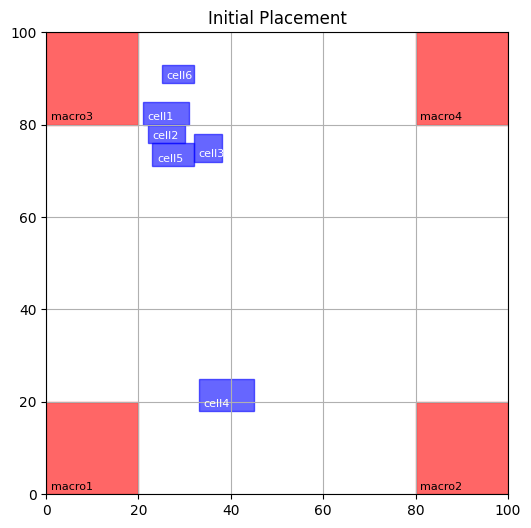

In [23]:
# Compute final HPWL after greedy placement
final_hpwl = calculate_total_hpwl(nets, env.all_cells)
print(final_hpwl)
plot_placement(env.cells, macros)

In [24]:
def export_pl_file(cells_dict, filename="greedy_output.pl"):
    with open(filename, "w") as f:
        for name, props in cells_dict.items():
            line = f"{name}\t{props['x']:.2f}\t{props['y']:.2f}\n"
            f.write(line)

export_pl_file(env.cells)


In [25]:
from google.colab import files
files.download("greedy_output.pl")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

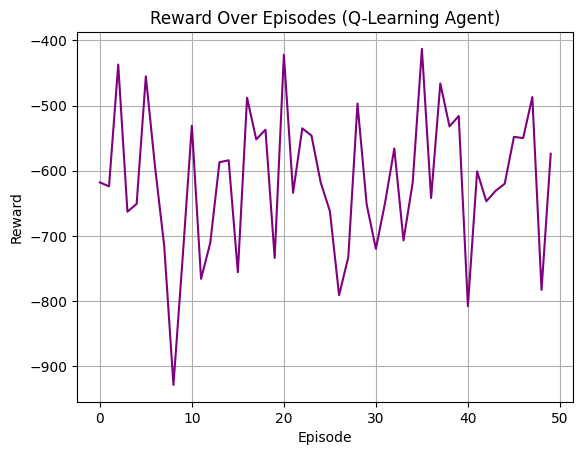

In [26]:
import numpy as np
from collections import defaultdict

class QLearningPlacementAgent:
    def __init__(self, env, alpha=0.1, gamma=0.9, epsilon=0.3):
        self.env = env
        self.alpha = alpha      # Learning rate
        self.gamma = gamma      # Discount factor
        self.epsilon = epsilon  # Exploration probability
        self.q_table = defaultdict(float)  # (state, action) → Q-value

    def get_state_key(self):
        # Quantize positions for state discretization
        state = tuple((cell["x"] // 5, cell["y"] // 5) for cell in self.env.cells.values())
        return state

    def select_action(self):
        cell_idx = random.randint(0, len(self.env.cell_names) - 1)
        dx, dy = random.choice([-5, 0, 5]), random.choice([-5, 0, 5])
        return (cell_idx, dx, dy)

    def run(self, episodes=50, steps_per_episode=100):
        reward_log = []

        for ep in range(episodes):
            self.env.reset()
            state_key = self.get_state_key()

            for step in range(steps_per_episode):
                if random.random() < self.epsilon:
                    action = self.select_action()  # Explore
                else:
                    # Exploit: choose best Q-value action among random 10 samples
                    candidates = [(self.select_action()) for _ in range(10)]
                    q_values = [self.q_table[(state_key, a)] for a in candidates]
                    action = candidates[np.argmax(q_values)]

                # Apply action
                cell_name = self.env.cell_names[action[0]]
                cell = self.env.cells[cell_name]
                old_x, old_y = cell["x"], cell["y"]
                self.env.step(action)
                new_state_key = self.get_state_key()
                reward = self.env.get_reward()

                # Update Q-table
                old_q = self.q_table[(state_key, action)]
                future_qs = [self.q_table[(new_state_key, self.select_action())] for _ in range(5)]
                max_future_q = max(future_qs)
                self.q_table[(state_key, action)] = old_q + self.alpha * (reward + self.gamma * max_future_q - old_q)

                # Revert action for next iteration
                cell["x"], cell["y"] = old_x, old_y
                self.env.all_cells[cell_name]["x"], self.env.all_cells[cell_name]["y"] = old_x, old_y

                state_key = new_state_key

            reward_log.append(self.env.get_reward())

        return reward_log

# Instantiate and train the Q-learning agent
q_agent = QLearningPlacementAgent(env)
q_rewards = q_agent.run(episodes=50, steps_per_episode=100)

# Plot the training reward trend
plt.plot(q_rewards, color='purple')
plt.title("Reward Over Episodes (Q-Learning Agent)")
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.grid(True)
plt.show()


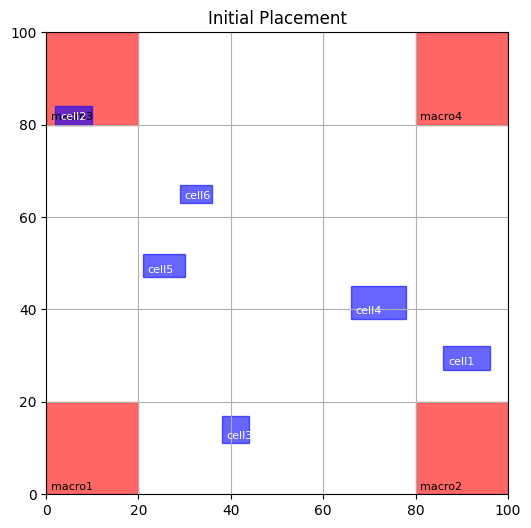

(574.0, 0, 0)

In [27]:
# Step 3A: Visualize final placement after Q-learning
plot_placement(env.cells, macros)

# Step 3B: Export Q-learning placement to .pl file
export_pl_file(env.cells, filename="qlearning_output.pl")

# Step 3C: Compute separate metrics

# Compute final HPWL
final_hpwl_q = calculate_total_hpwl(nets, env.all_cells)

# Count overlaps
def count_overlaps(cells_dict):
    names = list(cells_dict.keys())
    count = 0
    for i in range(len(names)):
        c1 = cells_dict[names[i]]
        for j in range(i + 1, len(names)):
            c2 = cells_dict[names[j]]
            if not (
                c1["x"] + c1["width"] <= c2["x"] or
                c2["x"] + c2["width"] <= c1["x"] or
                c1["y"] + c1["height"] <= c2["y"] or
                c2["y"] + c2["height"] <= c1["y"]
            ):
                count += 1
    return count

# Count boundary violations
def count_boundary_violations(cells_dict, width, height):
    violations = 0
    for props in cells_dict.values():
        if not (0 <= props["x"] <= width - props["width"]):
            violations += 1
        if not (0 <= props["y"] <= height - props["height"]):
            violations += 1
    return violations

# Gather metrics
overlap_count = count_overlaps(env.cells)
boundary_violations = count_boundary_violations(env.cells, CHIP_WIDTH, CHIP_HEIGHT)

# Display
final_hpwl_q, overlap_count, boundary_violations


In [28]:
from google.colab import files
files.download("qlearning_output.pl")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [29]:
# Optional: Upgrade PyTorch
!pip install torch torchvision --upgrade


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 821.2/821.2 MB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 393.1/393.1 MB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.9/8.9 MB 55.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 30.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 897.7/897.7 kB 27.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 571.0/571.0 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.2/200.2 MB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 46.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.2/158.2 MB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 216.6/216.6 MB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 156.8/156.8 MB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 201

In [30]:
!pip install gym
!pip install stable-baselines3


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.5/184.5 kB 3.2 MB/s eta 0:00:00


In [31]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class ActorCriticNetwork(nn.Module):
    def __init__(self, state_dim, action_dim, hidden_dim=128):
        super(ActorCriticNetwork, self).__init__()
        self.shared_fc1 = nn.Linear(state_dim, hidden_dim)
        self.shared_fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.actor_head = nn.Linear(hidden_dim, action_dim)
        self.critic_head = nn.Linear(hidden_dim, 1)

    def forward(self, state):
        x = F.relu(self.shared_fc1(state))
        x = F.relu(self.shared_fc2(x))
        logits = self.actor_head(x)
        value = self.critic_head(x)
        return logits, value

# Define input dimensions
state_dim = 12     # e.g., (x, y) for 6 cells
action_dim = 54    # e.g., 6 cells × 9 moves

# Test model
model = ActorCriticNetwork(state_dim, action_dim)
dummy_state = torch.randn(1, state_dim)
logits, value = model(dummy_state)

logits.shape, value.shape


(torch.Size([1, 54]), torch.Size([1, 1]))

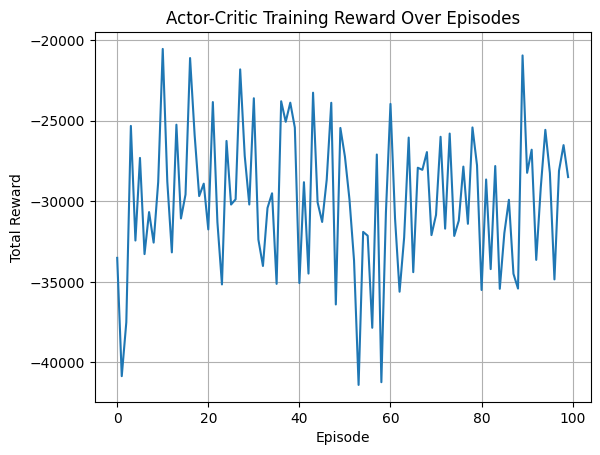

In [33]:
import torch.optim as optim
import numpy as np
import random

# 1. Build action mapping (ID <-> (cell_index, dx, dy))
def build_action_mapping(num_cells):
    movements = [(-5, -5), (-5, 0), (-5, 5),
                 (0, -5),  (0, 0),  (0, 5),
                 (5, -5),  (5, 0),  (5, 5)]
    action_map = []
    for cell_idx in range(num_cells):
        for move in movements:
            action_map.append((cell_idx, move[0], move[1]))
    return action_map

# For 6 cells → 6 × 9 = 54 actions
action_map = build_action_mapping(6)

# 2. Encode state: flatten all cell positions
def encode_state(cells_dict):
    state = []
    for cell in cells_dict.values():
        state.extend([cell["x"] / 100.0, cell["y"] / 100.0])  # Normalize to [0, 1]
    return torch.tensor(state, dtype=torch.float32).unsqueeze(0)

# 3. Actor-Critic training loop
def train_actor_critic(env, model, action_map, episodes=100, gamma=0.99):
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    all_rewards = []

    for episode in range(episodes):
        env.reset()
        total_reward = 0

        for step in range(50):  # per episode
            state_tensor = encode_state(env.cells)
            logits, value = model(state_tensor)
            probs = torch.softmax(logits, dim=-1)
            dist = torch.distributions.Categorical(probs)
            action_id = dist.sample()
            log_prob = dist.log_prob(action_id)

            action = action_map[action_id.item()]
            cell_name = env.cell_names[action[0]]
            cell = env.cells[cell_name]
            old_x, old_y = cell["x"], cell["y"]

            # Apply action
            env.step(action)
            reward = env.get_reward()
            total_reward += reward

            # Next state and value
            next_state_tensor = encode_state(env.cells)
            _, next_value = model(next_state_tensor)
            advantage = reward + gamma * next_value.item() - value.item()

            # Losses
            actor_loss = -log_prob * advantage
            critic_loss = advantage ** 2
            loss = actor_loss + critic_loss

            # Backpropagation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Revert move to maintain episode integrity
            cell["x"], cell["y"] = old_x, old_y
            env.all_cells[cell_name]["x"], env.all_cells[cell_name]["y"] = old_x, old_y

        all_rewards.append(total_reward)

    return all_rewards

# Train the model
ac_rewards = train_actor_critic(env, model, action_map, episodes=100)

# Plot training reward
import matplotlib.pyplot as plt
plt.plot(ac_rewards)
plt.title("Actor-Critic Training Reward Over Episodes")
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.grid(True)
plt.show()

In [34]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class ActorCriticNetwork(nn.Module):
    def __init__(self, state_dim, action_dim, hidden_dim=128):
        super(ActorCriticNetwork, self).__init__()
        self.shared_fc1 = nn.Linear(state_dim, hidden_dim)
        self.shared_fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.actor_head = nn.Linear(hidden_dim, action_dim)
        self.critic_head = nn.Linear(hidden_dim, 1)

    def forward(self, state):
        x = F.relu(self.shared_fc1(state))
        x = F.relu(self.shared_fc2(x))
        logits = self.actor_head(x)
        value = self.critic_head(x)
        return logits, value


In [35]:
# Define dimensions
state_dim = 12       # 6 cells → (x, y) * 6
action_dim = 54      # 6 cells × 9 moves

# Create the model
ac_model = ActorCriticNetwork(state_dim, action_dim)


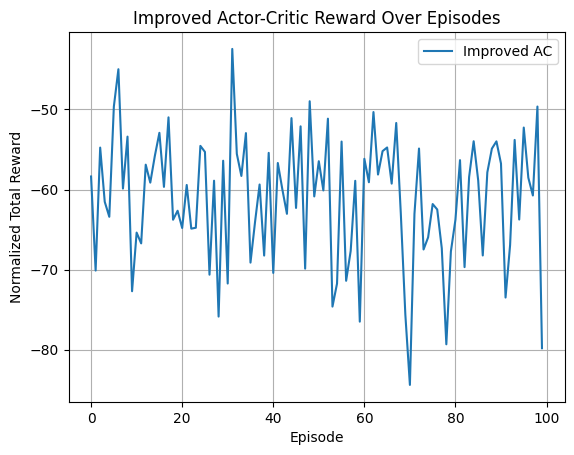

In [36]:
# Improved Actor-Critic Training with reward normalization and entropy bonus
def train_actor_critic_improved(env, model, action_map, episodes=100, gamma=0.99, entropy_coeff=0.01):
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    all_rewards = []

    for episode in range(episodes):
        env.reset()
        total_reward = 0

        for step in range(100):  # increased steps per episode
            state_tensor = encode_state(env.cells)
            logits, value = model(state_tensor)
            probs = torch.softmax(logits, dim=-1)
            dist = torch.distributions.Categorical(probs)
            action_id = dist.sample()
            log_prob = dist.log_prob(action_id)

            action = action_map[action_id.item()]
            cell_name = env.cell_names[action[0]]
            cell = env.cells[cell_name]
            old_x, old_y = cell["x"], cell["y"]

            # Apply action
            env.step(action)
            reward_raw = env.get_reward()

            # Normalize reward to reduce magnitude effect
            reward = max(min(reward_raw, 0), -10000) / 1000.0
            total_reward += reward

            # Compute advantage
            next_state_tensor = encode_state(env.cells)
            _, next_value = model(next_state_tensor)
            advantage = reward + gamma * next_value.item() - value.item()

            # Losses
            actor_loss = -log_prob * advantage
            critic_loss = advantage ** 2
            entropy = dist.entropy()
            loss = actor_loss + critic_loss - entropy_coeff * entropy

            # Backpropagation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Revert move to maintain deterministic episode
            cell["x"], cell["y"] = old_x, old_y
            env.all_cells[cell_name]["x"], env.all_cells[cell_name]["y"] = old_x, old_y

        all_rewards.append(total_reward)

    return all_rewards

# Train using the improved loop
ac_improved_rewards = train_actor_critic_improved(env, ac_model, action_map, episodes=100)

# Plot the improved training reward
plt.plot(ac_improved_rewards, label="Improved AC")
plt.title("Improved Actor-Critic Reward Over Episodes")
plt.xlabel("Episode")
plt.ylabel("Normalized Total Reward")
plt.grid(True)
plt.legend()
plt.show()
